# Computing NPP from CMEMS 3D ML derived Chla and Bbp products

The idea is to compute Net Primary Production (NPP) using Chlorophyll-a (Chla) and backscatter at 700 nm (Bbp) data from the Copernicus Marine Environment Monitoring Service (CMEMS) 3D products, aggregating observation to a degree grid and matching with modis PAR data, averaged over a week to match CMEMS product temporal resolution. 

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from argopy import ArgoFloat


In [2]:
dat = xr.open_dataset("../Data/Raw/cmems_obs-mob_glo_bgc-chl-poc_my_0.25deg_P7D-m_multi-vars_39.88W-10.12W_58.12N-64.88N_0.00-200.00m_2015-01-07-2023-12-27.nc")

Open a float dataset and select relevent vars


In [46]:


WMO = 6904185 # Use any f

argo_ds = ArgoFloat(WMO).open_dataset("Sprof")

argo_filtered = argo_ds[['LATITUDE', 'LONGITUDE', 'JULD', 'CHLA_ADJUSTED', 'BBP700', 'PRES']]

Bin the data to a 5m resolution

In [47]:
bins = np.arange(0, 200, 5)

argo_binned = argo_filtered.argo.groupby_pressure_bins(bins, 'PRES',  select = 'median')
argo_binned["date"] = xr.DataArray(
    pd.to_datetime(argo_binned["JULD"].values),
    dims=("N_PROF",)
) #Making a date variable for clarity when matching with model data

In [48]:
# Swap the profile dimension to use the datetime coordinate and drop the old index
if "N_PROF" in argo_binned.dims:
    argo_binned = argo_binned.swap_dims({"N_PROF": "date"})
    if "N_PROF" in argo_binned.coords:
        argo_binned = argo_binned.drop_vars("N_PROF")

In [49]:
argo_binned = argo_binned.where(argo_binned['date'] < max(dat['time'].values), drop =True)

In [50]:
argo_binned["CHLA_ML"] = dat["chl"].sel(
    longitude=argo_binned["LONGITUDE"], 
    latitude=argo_binned["LATITUDE"], 
    time=argo_binned["date"], 
    depth=argo_binned['STD_PRES_BINS'],
    method="nearest"
)

argo_binned["BBP700_ML"] = dat["bbp"].sel(
    longitude=argo_binned["LONGITUDE"], 
    latitude=argo_binned["LATITUDE"], 
    time=argo_binned["date"], 
    depth=argo_binned['STD_PRES_BINS'],
    method="nearest"
)

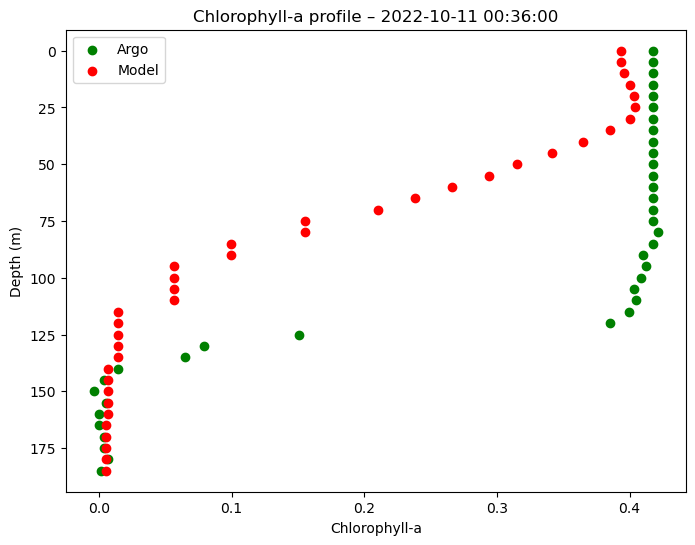

In [51]:
profile_to_check = 18
plot_prof = argo_binned.sel(date = argo_binned.date[profile_to_check])


fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(
    plot_prof["CHLA_ADJUSTED"],
    plot_prof["STD_PRES_BINS"],
    c="green",
    label="Argo"
)

ax.scatter(
    plot_prof["CHLA_ML"],
    plot_prof["STD_PRES_BINS"],
    c="red",
    label="Model"
)

ax.set_title(
    f"Chlorophyll-a profile – {pd.to_datetime(plot_prof.JULD.values)}"
)
ax.set_xlabel("Chlorophyll-a")
ax.set_ylabel("Depth (m)")
ax.invert_yaxis()
ax.legend()



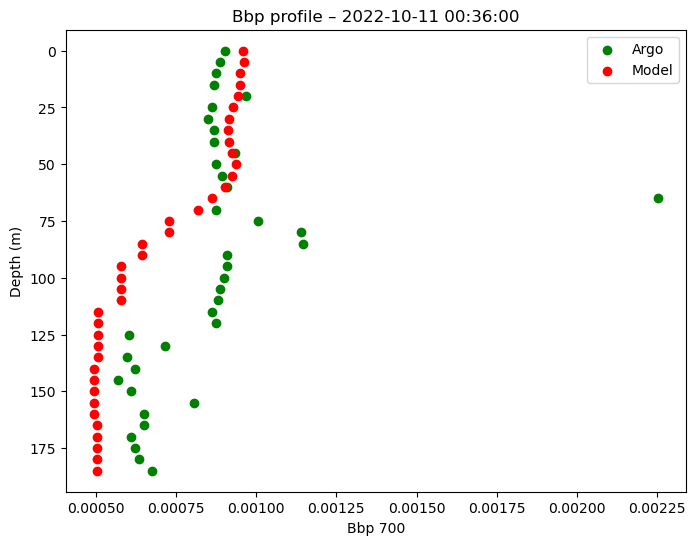

In [52]:
plot_prof = argo_binned.sel(date = argo_binned.date[profile_to_check])


fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(
    plot_prof["BBP700"],
    plot_prof["STD_PRES_BINS"],
    c="green",
    label="Argo"
)

ax.scatter(
    plot_prof["BBP700_ML"],
    plot_prof["STD_PRES_BINS"],
    c="red",
    label="Model"
)

ax.set_title(
    f"Bbp profile – {pd.to_datetime(plot_prof.JULD.values)}"
)
ax.set_xlabel("Bbp 700")
ax.set_ylabel("Depth (m)")
ax.invert_yaxis()
ax.legend()

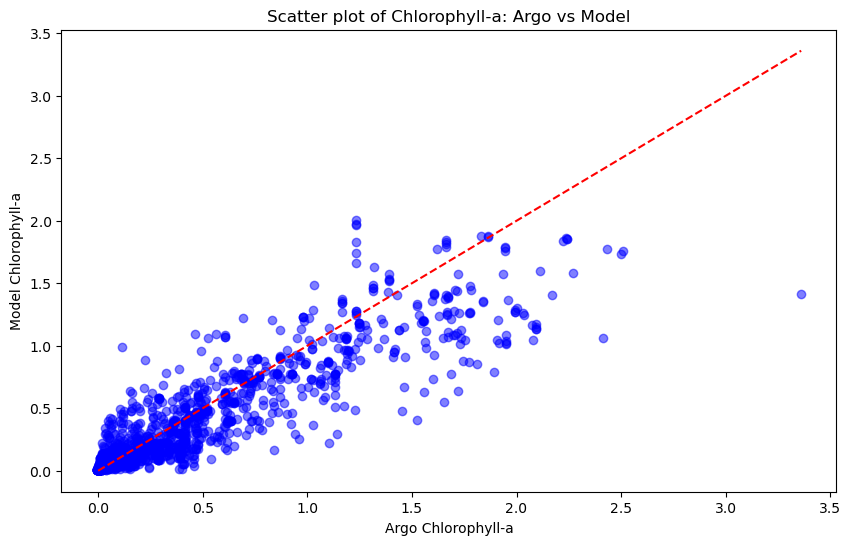

In [53]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(
    argo_binned["CHLA_ADJUSTED"],
    argo_binned["CHLA_ML"],
    c="blue",
    alpha=0.5
)
ax.set_title("Scatter plot of Chlorophyll-a: Argo vs Model")
ax.set_xlabel("Argo Chlorophyll-a")
ax.set_ylabel("Model Chlorophyll-a")
ax.plot([0, np.nanmax(argo_binned["CHLA_ADJUSTED"])], [0, np.nanmax(argo_binned["CHLA_ADJUSTED"])], 'r--')
plt.show()

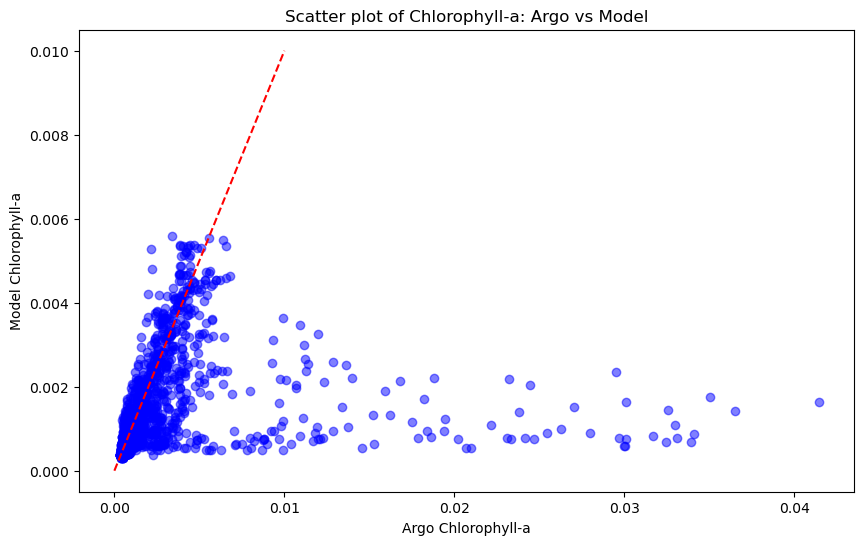

In [56]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(
    argo_binned["BBP700"],
    argo_binned["BBP700_ML"],
    c="blue",
    alpha=0.5
)
ax.set_title("Scatter plot of Chlorophyll-a: Argo vs Model")
ax.set_xlabel("Argo Chlorophyll-a")
ax.set_ylabel("Model Chlorophyll-a")
ax.plot([0, 0.01], [0, 0.01], 'r--')
plt.show()